In [9]:
import pandas as pd
import pm4py
import os

os.environ["PATH"] += os.pathsep + 'C:/Users/25052288840/Downloads/Graphviz/bin'

In [18]:
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.objects.log.importer.xes import importer as xes_importer

model_path = 'L1 -  Tempo fixed.xml'
log_path = 'Log sintetico L1 -  Tempo fixed_simulation_logs.xes'

In [11]:
bpmn = bpmn_importer.apply(model_path)

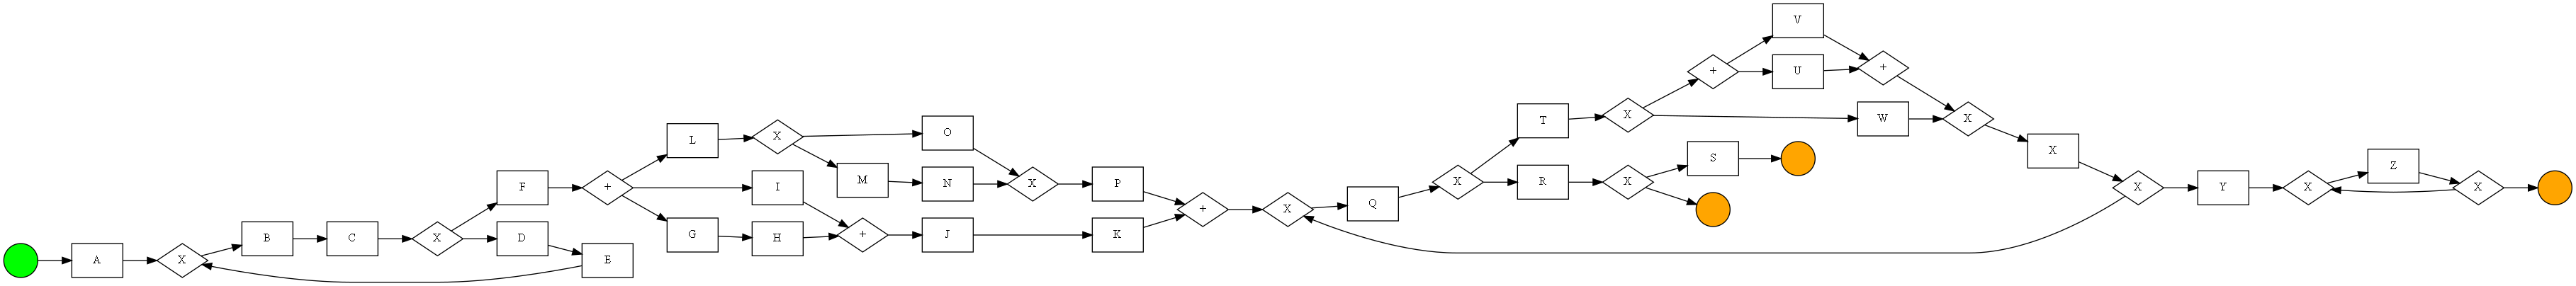

In [12]:
pm4py.view_bpmn(bpmn)

In [41]:
from pm4py.objects.conversion.bpmn import converter as bpmn_converter

net, im, fm = bpmn_converter.apply(bpmn)

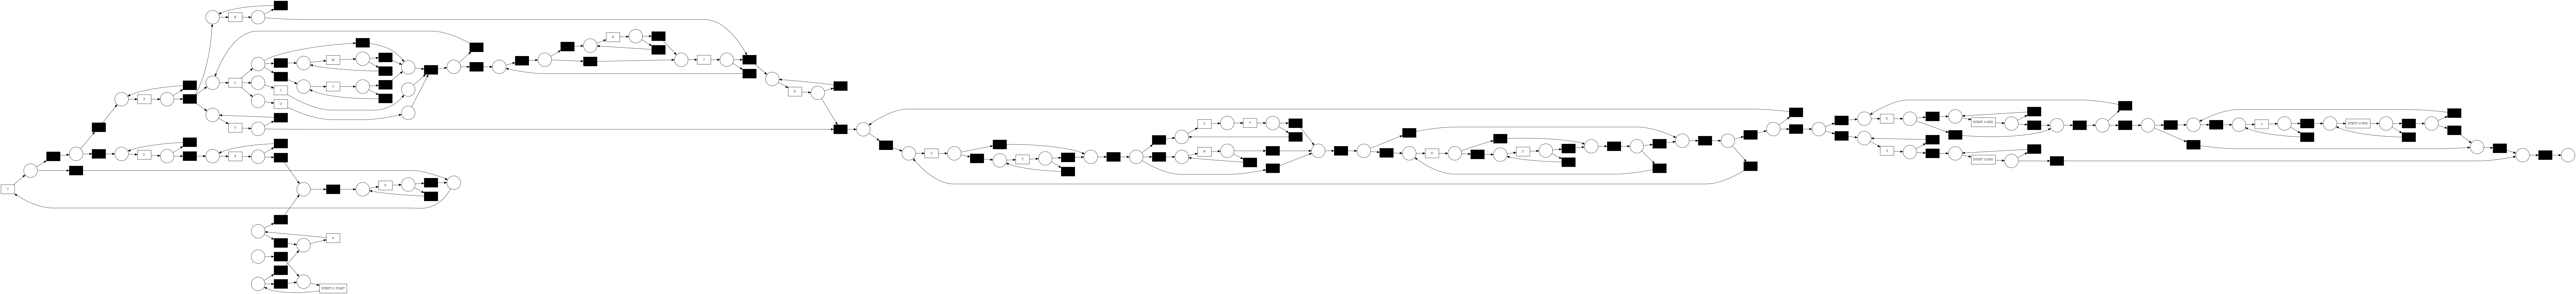

In [43]:
pm4py.view_petri_net(net)

In [20]:
log = xes_importer.apply(log_path)

In [21]:
print(log[0]) #prints the first trace of the log
print(len(log[0]))
print(log[0][0]) #prints the first event of the first trace

{'attributes': {'concept:name': '0', 'LogType': 'MXML.EnactmentLog'}, 'events': [{'elementId': 'Id_a2ceb9a1-d355-42c7-a042-52b28d6cbb68', 'concept:name': 'EVENT 21 START', 'processId': 'Id_85296890-732f-4648-bf7e-5a724ffb6db9', 'lifecycle:transition': 'assign', 'time:timestamp': datetime.datetime(2021, 3, 3, 17, 52, tzinfo=datetime.timezone.utc)}, '..', {'elementId': 'Id_1196e68a-6a73-4fa6-b3f5-791ed8883a10', 'concept:name': 'EVENT 19 END', 'processId': 'Id_85296890-732f-4648-bf7e-5a724ffb6db9', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2021, 3, 4, 10, 40, 10, tzinfo=datetime.timezone.utc)}]}
48
{'elementId': 'Id_a2ceb9a1-d355-42c7-a042-52b28d6cbb68', 'concept:name': 'EVENT 21 START', 'processId': 'Id_85296890-732f-4648-bf7e-5a724ffb6db9', 'lifecycle:transition': 'assign', 'time:timestamp': datetime.datetime(2021, 3, 3, 17, 52, tzinfo=datetime.timezone.utc)}


In [22]:
print(log[1]) #prints the first trace of the log
print(len(log[1]))

{'attributes': {'concept:name': '3', 'LogType': 'MXML.EnactmentLog'}, 'events': [{'elementId': 'Id_a2ceb9a1-d355-42c7-a042-52b28d6cbb68', 'concept:name': 'EVENT 21 START', 'processId': 'Id_85296890-732f-4648-bf7e-5a724ffb6db9', 'lifecycle:transition': 'assign', 'time:timestamp': datetime.datetime(2021, 3, 4, 9, 30, tzinfo=datetime.timezone.utc)}, '..', {'elementId': 'Id_37c930ef-a4e1-48ad-afe9-470668fc4d59', 'concept:name': 'EVENT 20 END', 'processId': 'Id_85296890-732f-4648-bf7e-5a724ffb6db9', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2021, 3, 4, 16, 40, tzinfo=datetime.timezone.utc)}]}
93


In [23]:
log[1].attributes['concept:name']

'3'

In [24]:
counter = [(trace.attributes['concept:name'], len(trace)) for trace in log]

In [25]:
len_events = [item[1] for item in counter]

In [26]:
n_traces = len(log)
n_eventos = sum(len_events)
max_eventos = max(len_events)
min_eventos = min(len_events)

In [27]:
print(f'Total de casos: {n_traces}')
print(f'Total de eventos: {n_eventos}')
print(f'Eventos por caso: Mínimo {min_eventos}  Máximo {max_eventos}  Média {n_eventos / n_traces:0.2f}')

Total de casos: 30
Total de eventos: 1773
Eventos por caso: Mínimo 48  Máximo 93  Média 59.10


In [28]:
#Exibir o comprimento de alguns traces
import random
sampled_lens = random.sample(len_events, 20)
print(sampled_lens)

[93, 51, 54, 75, 48, 48, 48, 66, 63, 54, 63, 63, 54, 75, 78, 51, 51, 51, 48, 63]


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

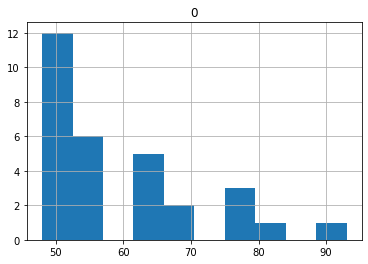

In [29]:
#Histograma do comprimento dos traces
df = pd.DataFrame(len_events)
df.hist()

In [30]:
start_activities = pm4py.get_start_activities(log)
end_activities = pm4py.get_end_activities(log)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Start activities: {'EVENT 21 START': 30}
End activities: {'EVENT 19 END': 15, 'EVENT 20 END': 11, 'EVENT 18 END': 4}


In [31]:
petri_net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log)

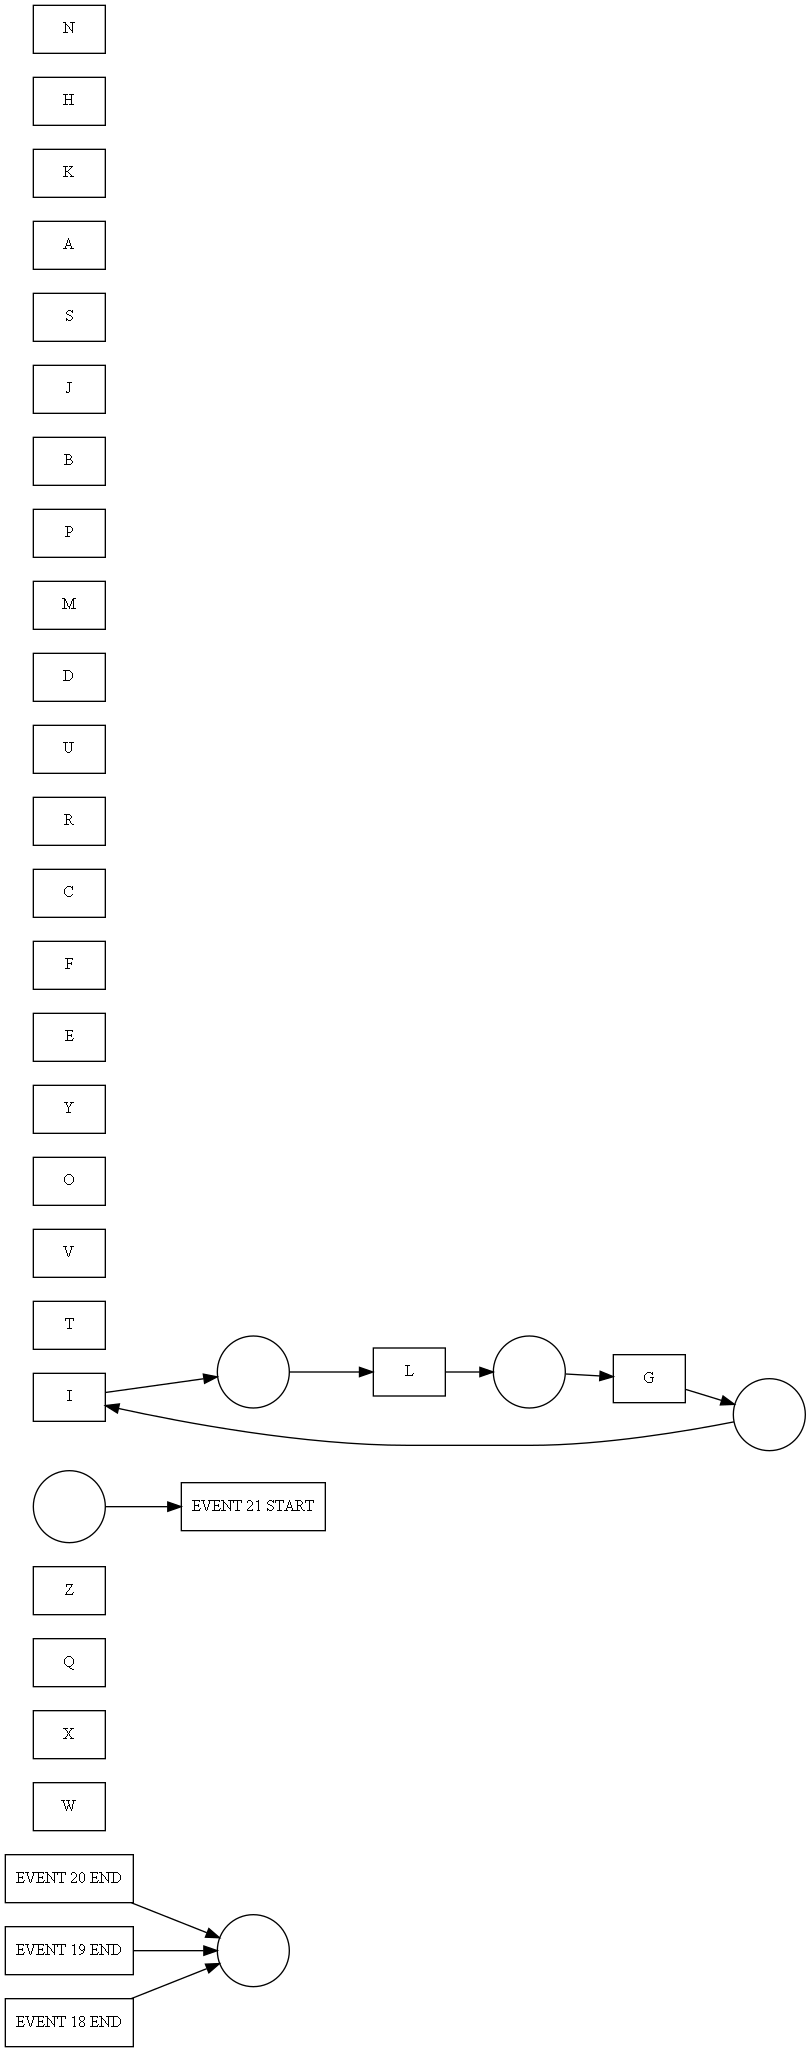

In [32]:
pm4py.view_petri_net(petri_net)

In [33]:
process_tree = pm4py.discover_process_tree_inductive(log)

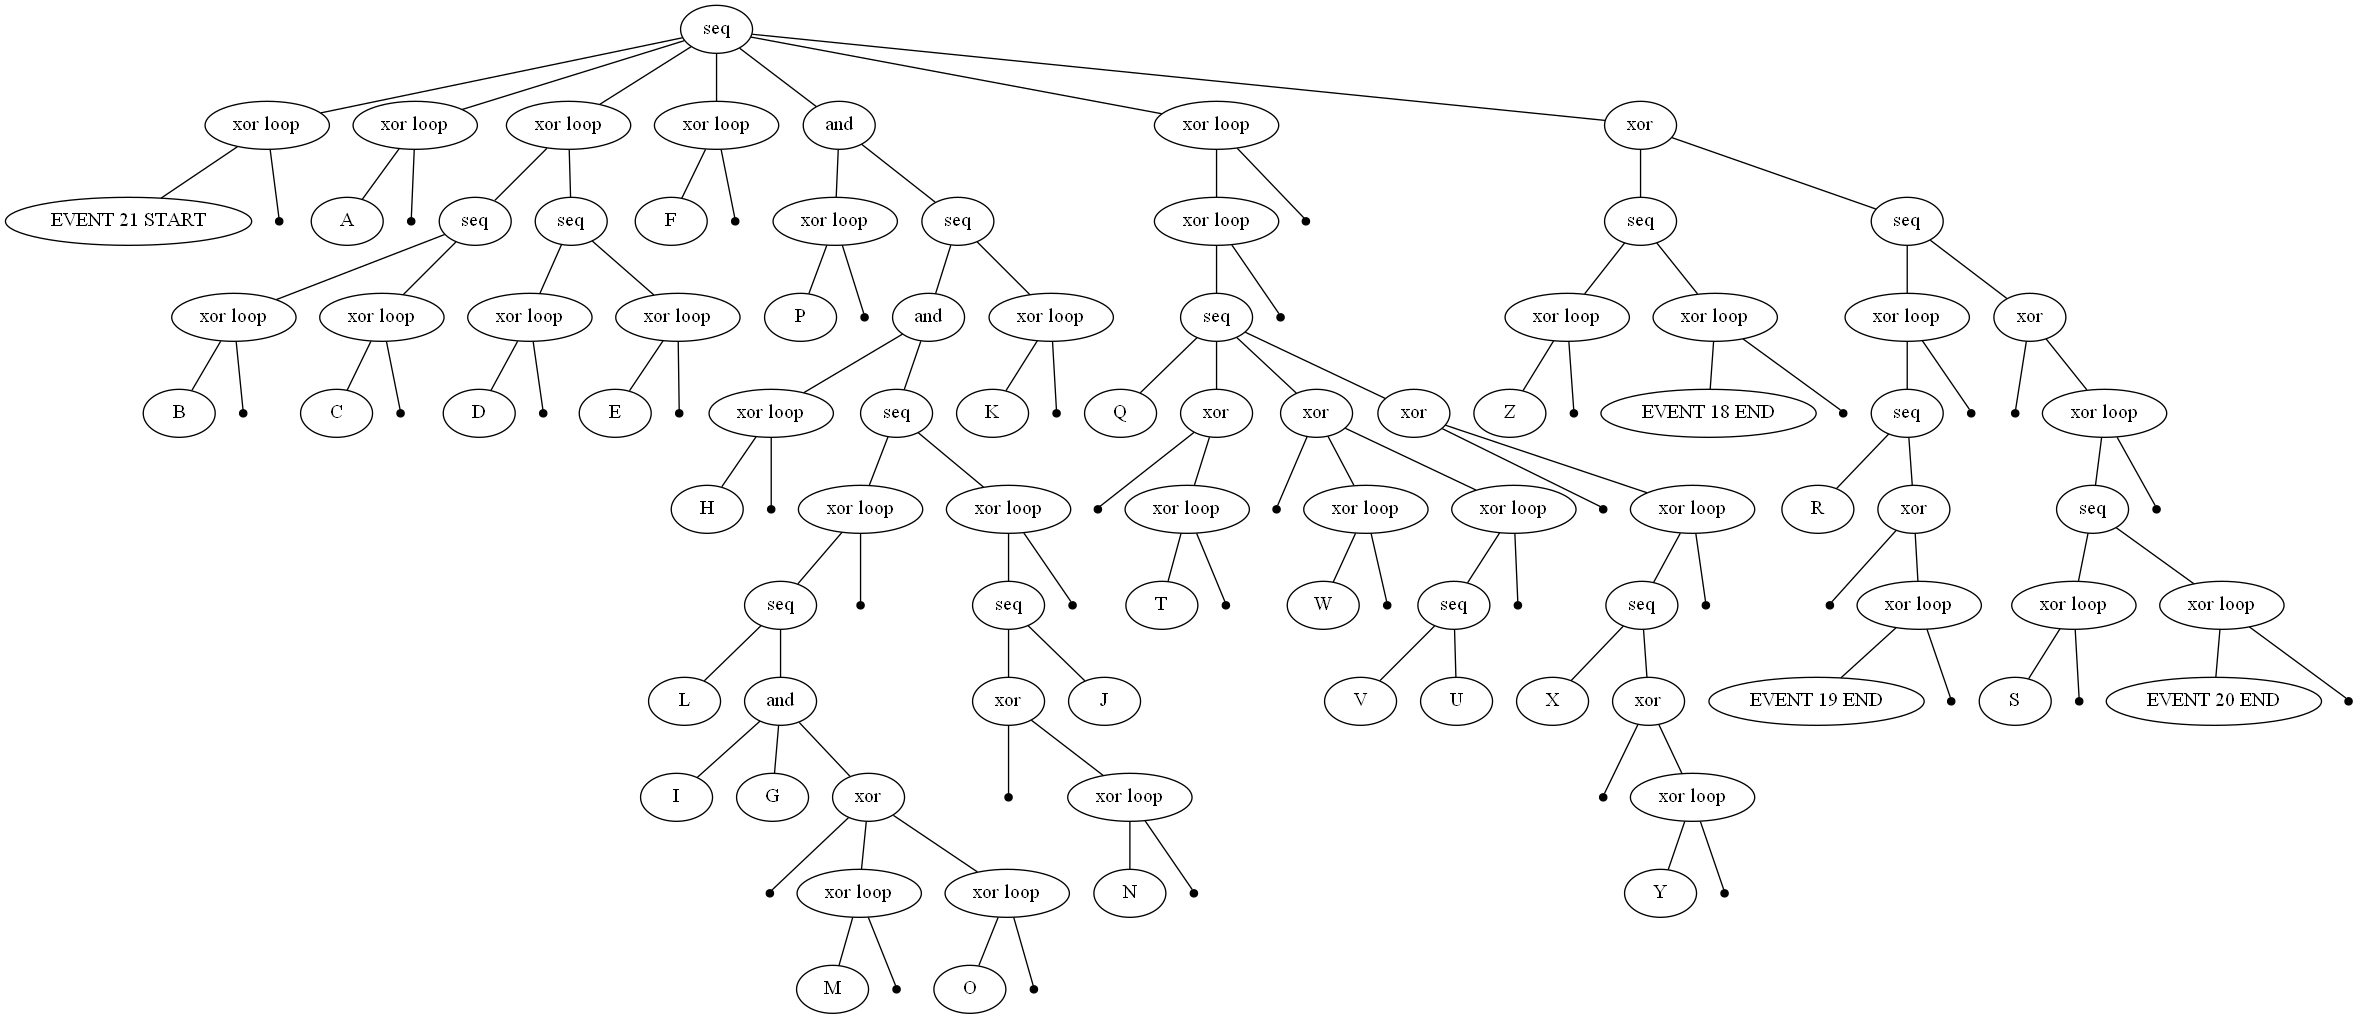

In [34]:
pm4py.view_process_tree(process_tree)

In [35]:
bpmn = pm4py.convert_to_bpmn(process_tree)

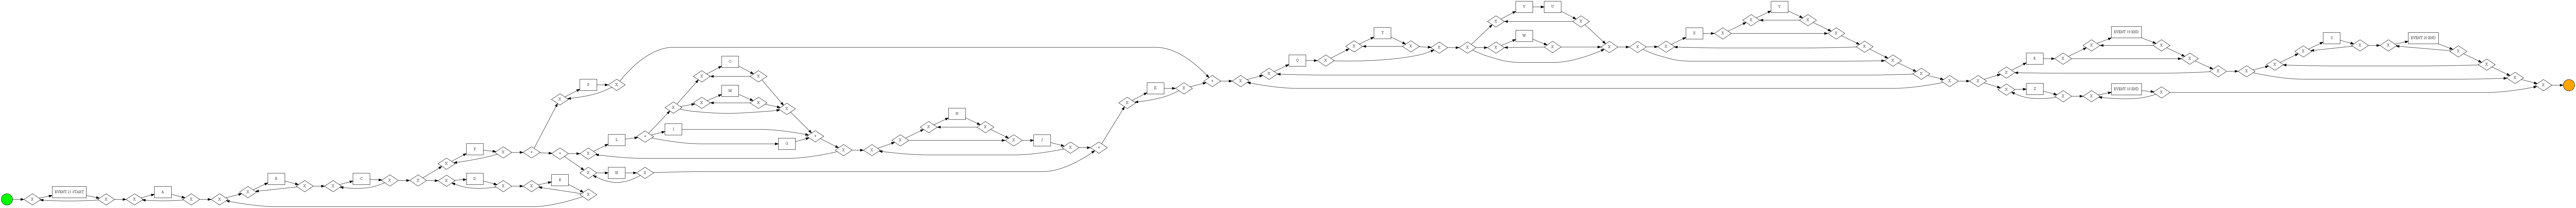

In [36]:
pm4py.view_bpmn(bpmn)

In [79]:
from pm4py.algo.analysis.woflan import algorithm as woflan
from pm4py.algo.conformance.alignments import algorithm as alignments
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

def cal_measure(xes_log, petrinet, initial_marking, final_marking):
    parameters = {replay_fitness_evaluator.token_replay.Parameters.ACTIVITY_KEY: 'concept:name',
                  replay_fitness_evaluator.alignment_based.Parameters.ACTIVITY_KEY: 'concept:name',
                  woflan.Parameters.RETURN_ASAP_WHEN_NOT_SOUND: True,
                  woflan.Parameters.PRINT_DIAGNOSTICS: False, woflan.Parameters.RETURN_DIAGNOSTICS: False,
                  alignments.Parameters.SHOW_PROGRESS_BAR: False}
    is_sound = woflan.apply(petrinet, initial_marking, final_marking, parameters=parameters)
    if is_sound == True:
        fitness = replay_fitness_evaluator.apply(xes_log, petrinet, initial_marking, final_marking,
                                           parameters=parameters,
                                           variant=replay_fitness.algorithm.Variants.ALIGNMENT_BASED)
        precision = precision_evaluator.algorithm.apply(xes_log, petrinet, initial_marking, final_marking,
                                              parameters=parameters, variant=calc_precision.Variants.ALIGN_ETCONFORMANCE)
        f_score = 2 * ((fitness['averageFitness'] * precision) / (fitness['averageFitness'] + precision))
        print('sound')
    else:
        fitness = replay_fitness_evaluator.apply(xes_log, petrinet, initial_marking, final_marking, 
                                           parameters=parameters, variant=replay_fitness.algorithm.Variants.TOKEN_BASED)
        precision = precision_evaluator.apply(xes_log, petrinet, initial_marking, final_marking, 
                                                  parameters=parameters, variant=calc_precision.Variants.ETCONFORMANCE_TOKEN)
        print('unsound')
    generaliz = generalization_evaluator.apply(xes_log, petrinet, initial_marking, final_marking,
                                               parameters=parameters, variant=calc_generaliz.Variants.GENERALIZATION_TOKEN)
    simplic = simplicity_evaluator.apply(petrinet)
    f_score = 2 * ((fitness['log_fitness'] * precision) / (fitness['log_fitness'] + precision))
    print('f_score:', f_score, 'fitness:', fitness['log_fitness'], 
              'precision:', precision, 'generaliz:', generaliz, 'simplic:', simplic)


In [80]:
cal_measure(log, petri_net, initial_marking, final_marking)


unsound



f_score: 0.03683241252302025 fitness: 0.7692307692307692 precision: 0.018867924528301883 generaliz: 0.8381417726847994 simplic: 1.0


In [81]:
cal_measure(log, net, initial_marking, final_marking)


unsound



f_score: 0.9937759336099585 fitness: 0.9876288659793815 precision: 1.0 generaliz: 0.7195866860285323 simplic: 0.7006802721088436
